In [21]:
import os
import matplotlib.pyplot as plt
import jax.numpy as jnp 
import jax 
import equinox as eqx
from typing import Tuple, Callable
import optax
import jax.tree_util as jtu

Lets load some images.

In [3]:
def load_data(path, count=100):
    # load all images from this path
    images = []
    i = 0
    for file in os.listdir(path):
        i += 1
        if i > count:
            break
        if file.endswith(".jpg"):
            images.append(plt.imread(os.path.join(path, file)))

    return images

def preprocess(images, size=32, batch_size=32, batch_count=10):
    # resize with jax vectorization
    images = [jax.image.resize(image, (size, size, 3), method="linear") for image in images]
    # reshape
    images = jnp.array(images)
    # normalize
    images = images / 255.0

    batches = images.reshape((batch_count, batch_size, size, size, 3))

    return batches

batch_size = 16
batch_count = 16
images_raw = load_data("data", count=batch_size * batch_count)
batches = preprocess(images_raw, size=32, batch_size=batch_size, batch_count=batch_count)

2024-06-05 16:16:39.371767: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


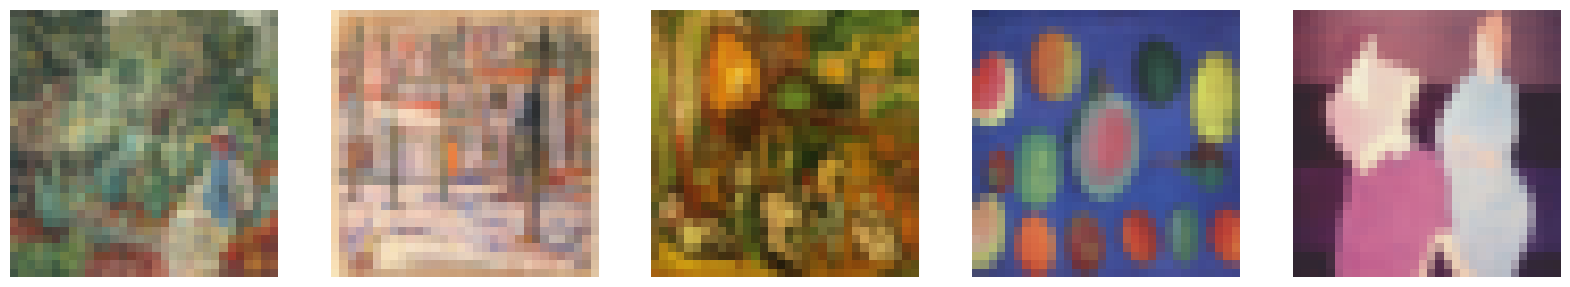

In [7]:
# generate 5 plots in a row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(batches[0][i])
    axs[i].axis("off")

In [10]:
class DoubleConv(eqx.Module):
    conv_1: eqx.nn.Conv
    conv_2: eqx.nn.Conv
    activation : Callable

    def __init__(
        self, 
        num_spatial_dims: int,
        in_channels: int,
        out_channels: int,
        activation: Callable,
        padding: str,
        key
    ):
        key1, key2 = jax.random.split(key)
        self.conv_1 = eqx.nn.Conv(num_spatial_dims, in_channels, out_channels, kernel_size=3, padding=padding, key=key1)
        self.conv_2 = eqx.nn.Conv(num_spatial_dims, out_channels, out_channels, kernel_size=3, padding=padding, key=key2)
        self.activation = activation
        
    def __call__(self, x):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        return x


In [11]:
class Generator(eqx.Module):
    lifting : DoubleConv
    down_sampling : list[eqx.nn.Conv]
    left_arc : list[eqx.nn.Conv]
    right_arc : list[eqx.nn.Conv]
    up_sampling : list[eqx.nn.Conv]
    projection : eqx.nn.Conv

    def __init__(
        self,
        num_spatial_dims: int,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        num_levels: int,
        activation: Callable,
        padding: str,
        key):

        key, key_liftiing, key_projection = jax.random.split(key, 3)

        self.lifting = DoubleConv(
            num_spatial_dims, 
            in_channels,
            hidden_channels,
            activation,
            padding,
            key_liftiing
        )

        self.projection = eqx.nn.Conv(
            num_spatial_dims,
            hidden_channels,
            out_channels,
            kernel_size=1,
            padding=padding,
            key=key_projection
        )

        channels_per_level = [hidden_channels * 2**i for i in range(num_levels + 1)]

        self.down_sampling = []
        self.left_arc = []
        self.right_arc = []
        self.up_sampling = []

        for (upper_level_channels, lower_level_channels) in zip(
            channels_per_level[:-1], channels_per_level[1:]):
            key, key_down, key_left, key_right, key_up = jax.random.split(key, 5)

            self.down_sampling.append(
                eqx.nn.Conv(
                    num_spatial_dims,
                    upper_level_channels,
                    upper_level_channels,
                    kernel_size=3,
                    stride=2,
                    padding=padding,
                    key=key_down
                )
            )

            self.left_arc.append(
                DoubleConv(
                    num_spatial_dims,
                    upper_level_channels,
                    lower_level_channels,
                    activation,
                    padding,
                    key_left
                )
            )

            self.right_arc.append(
                DoubleConv(
                    num_spatial_dims,
                    lower_level_channels,
                    upper_level_channels,
                    activation,
                    padding,
                    key_right
                )
            )

            self.up_sampling.append(
                eqx.nn.ConvTranspose(
                    num_spatial_dims,
                    lower_level_channels,
                    upper_level_channels,
                    kernel_size=3,
                    stride=2,
                    padding=padding,
                    key=key_up
                )
            )

    def __call__(self, x):
        print(x.shape)
        x = self.lifting(x)
        residuals = []

        for down, left in zip(self.down_sampling, self.left_arc):
            residuals.append(x)
            x = down(x)
            x = left(x)

        for right, up in zip(reversed(self.right_arc), reversed(self.up_sampling)):
            x = up(x)
            x = jnp.concatenate([x, residuals.pop()], axis=0)
            x = right(x)

        x = self.projection(x)
        
        return x

In [12]:
class Discriminator(eqx.Module):
    conv_1: eqx.nn.Conv
    conv_2: eqx.nn.Conv
    conv_3: eqx.nn.Conv
    conv_4: eqx.nn.Conv
    projection: eqx.nn.Conv

    def __init__(
        self,
        num_spatial_dims: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        activation: Callable,
        padding: str,
        key
    ):
        key, key_conv1, key_conv2, key_conv3, key_conv4, key_projection = jax.random.split(key, 6)

        self.conv_1 = eqx.nn.Conv(
            num_spatial_dims,
            in_channels,
            hidden_channels,
            kernel_size=3,
            padding=padding,
            key=key_conv1
        )

        self.conv_2 = eqx.nn.Conv(
            num_spatial_dims,
            hidden_channels,
            hidden_channels,
            kernel_size=3,
            padding=padding,
            key=key_conv2
        )

        self.conv_3 = eqx.nn.Conv(
            num_spatial_dims,
            hidden_channels,
            hidden_channels,
            kernel_size=3,
            padding=padding,
            key=key_conv3
        )

        self.conv_4 = eqx.nn.Conv(
            num_spatial_dims,
            hidden_channels,
            out_channels,
            kernel_size=3,
            padding=padding,
            key=key_conv4
        )

        self.projection = eqx.nn.Conv(
            num_spatial_dims,
            out_channels,
            1,
            kernel_size=1,
            padding=padding,
            key=key_projection
        )

    def __call__(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.projection(x)
        return x

In [22]:
def count_parameters(model: eqx.Module):
    return  sum(p.size for p in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))

In [23]:
key = jax.random.PRNGKey(0)
gen_key, disc_key, noise_key = jax.random.split(key, 3)

generator = Generator(
    num_spatial_dims=2,
    in_channels=3,
    out_channels=3,
    hidden_channels=8,
    num_levels=3,
    activation=jax.nn.relu,
    padding="SAME",
    key=gen_key)

discriminator = Discriminator(
    num_spatial_dims=2,
    in_channels=3,
    hidden_channels=8,
    out_channels=8,
    activation=jax.nn.relu,
    padding="SAME",
    key=disc_key)

print(f"Generator parameters: {count_parameters(generator)}")
print(f"Discriminator parameters: {count_parameters(discriminator)}")

Generator parameters: 146435
Discriminator parameters: 1985


In [20]:

input_shape = (1, 32, 32, 3)
input_data = jax.random.normal(noise_key, input_shape)
output_data = generator(input_data)

(1, 32, 32, 3)


ValueError: ('Input to `Conv` needs to have rank 3,', ' but input has shape (1, 32, 32, 3).')

In [14]:
from functools import partial

def reconstruction_loss(network_params : optax.Params,  network : nn.Module, images : jnp.ndarray):
  # print(images.shape)
  prediction = network.apply(network_params, images)
  # print(prediction.shape)
  # print(prediction.shape, images.shape)
  loss = jnp.mean(jnp.sum(jnp.square(prediction - images), axis=(-1)))
  return loss

@partial(jax.jit, static_argnums=(1,2))
def train_step(
  batch : jnp.ndarray,
  network : nn.Module,
  optimizer : optax.GradientTransformation,
  optimizer_state : optax.OptState,
  network_params : optax.Params):

  grad_fn = jax.value_and_grad(reconstruction_loss, argnums=0)
  loss, grads = grad_fn(network_params, network, batch)

  updates, new_opt_state = optimizer.update(grads, optimizer_state)

  new_network_params = optax.apply_updates(network_params, updates)

  return loss, new_network_params, new_opt_state

NameError: name 'nn' is not defined

In [ ]:
init_rng = jax.random.key(0)

learning_rate = 0.003

autoencoder = Autoencoder(n_channels=3)

network_params = autoencoder.init(init_rng, batches[0][0])
print(batches[0].shape)
# autoencoder_params = autoencoder_state
optimizer = optax.adam(learning_rate)
optimizer_state = optimizer.init(network_params)

num_epochs = 60

for epoch in range(num_epochs):

    def body_func(i, state):
        loss_sum, network_params, optimizer_state = state
        loss, network_params, optimizer_state = train_step(batches[i], autoencoder, optimizer, optimizer_state, network_params)
        return loss_sum + loss, network_params, optimizer_state
    
    state = (0., network_params, optimizer_state)
    state = jax.lax.fori_loop(0, len(batches), body_func, state)

    loss, network_params, optimizer_state = state

    print(f"Epoch {epoch}, Loss: {loss}")